# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [17]:
import pandas as pd 
import numpy as np
import seaborn as sns
import LinearModelsPS2_post as lm
import scipy
from tabulate import tabulate
from scipy.stats import chi2

In [18]:
dat = pd.read_csv('firms.csv')
#Modify x to only use the first 3 time periods
dat = dat[dat["year"] < 1971]
print(dat)

      firmid  year      lcap      lemp      ldsa
0          1  1968  0.998602 -0.242185  0.349053
1          1  1969  0.925214 -0.241278  0.312492
2          1  1970  0.879616 -0.265134  0.347566
12         2  1968 -0.069588 -0.323021 -0.945831
13         2  1969 -0.056724 -0.358177 -1.143830
...      ...   ...       ...       ...       ...
5269     440  1969 -0.228757  0.031242 -0.246864
5270     440  1970 -0.038354  0.062158 -0.345710
5280     441  1968 -1.618390 -1.944210 -2.032340
5281     441  1969 -1.635030 -1.856580 -2.011210
5282     441  1970 -1.454890 -1.538940 -1.371550

[1323 rows x 5 columns]


In [19]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
4489,375,1969,0.072970,-0.147614,0.071945
2114,177,1970,0.338711,0.540357,0.461261
2689,225,1969,-1.701520,-1.782270,-2.026340
3060,256,1968,-1.814780,-1.243340,-1.533240
3169,265,1969,-0.137299,0.239697,-0.053566


In [20]:
dat.year.unique()

array([1968, 1969, 1970])

# Descriptives

In [21]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,1323.000000,1323.000000,1.323000e+03,1.323000e+03,1.323000e+03
mean,221.000000,1969.000000,-3.432577e-08,5.291005e-09,3.253968e-08
std,127.353547,0.816805,1.367661e+00,1.212370e+00,1.238870e+00
min,1.000000,1968.000000,-3.864950e+00,-3.108660e+00,-3.433130e+00
25%,111.000000,1968.000000,-9.629080e-01,-8.435585e-01,-9.082370e-01
50%,221.000000,1969.000000,-1.016350e-01,-1.141760e-01,-1.142770e-01
75%,331.000000,1970.000000,9.708763e-01,8.067791e-01,8.648864e-01
max,441.000000,1970.000000,3.993508e+00,3.187258e+00,3.418170e+00


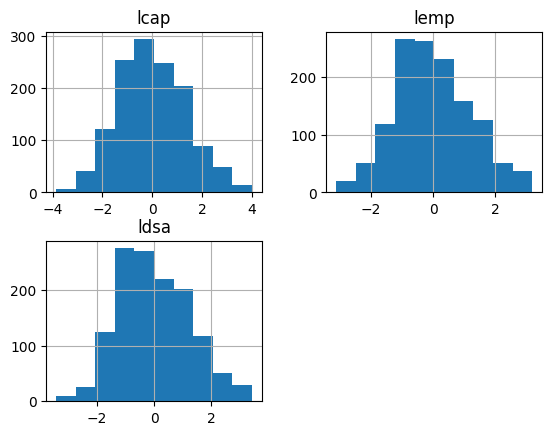

In [22]:
dat[['lcap','lemp','ldsa']].hist();

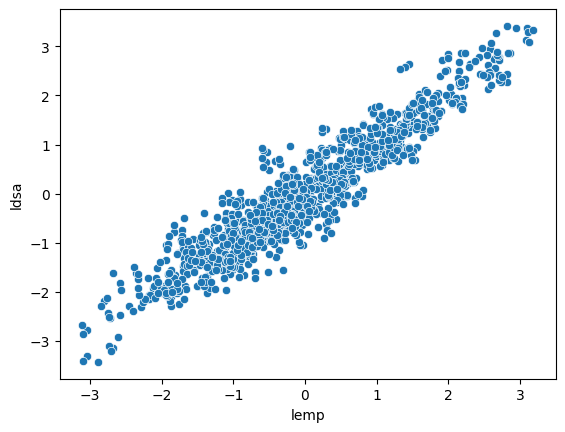

In [23]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [24]:
dat.ldsa.values.shape

(1323,)

In [25]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=3


Extract data from `pandas` to `numpy` arrays. 

In [26]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])
xlbl = ["constant", "lcap", "lemp"]
ylbl = ["ldsa"]

In [45]:
# Pooled OLS estimation
estimation_OLS = lm.estimate(y, X, robust_se=True, T=T)

# Round estimated values to 3 decimals
for key in ["b_hat", "se", "t_values"]:
    estimation_OLS[key] = np.round(estimation_OLS[key], 5)

lm.print_table((ylbl, xlbl), estimation_OLS, title="Pooled OLS")

# Wald test for H0: B_L + B_K = 1 (i.e., B_L + B_K - 1 = 0)
C_OLS = np.array([[0, 1, 1]])  # Restriction matrix
betas_OLS = estimation_OLS["b_hat"]
cov_OLS = estimation_OLS["cov"]

# Compute Wald test statistic
wald_OLS = (C_OLS @ betas_OLS).T @ np.linalg.inv(C_OLS @ cov_OLS @ C_OLS.T) @ (C_OLS @ betas_OLS)

# Compute p-value
p_value_OLS = 1 - scipy.stats.chi2.cdf(wald_OLS, df=1)

# Display results with 3 decimals
print(f"Wald test statistic (OLS): {wald_OLS[0][0]:.3f}")
print(f"p-value (OLS): {p_value_OLS[0][0]:.3f}")

Pooled OLS
Dependent variable: ['ldsa']

             Beta       Se    t-values
--------  -------  -------  ----------
constant  0        0.01658     0
lcap      0.68603  0.03481    19.71
lemp      0.27681  0.03068     9.02351
R² = 0.917
σ² = 0.127
Wald test statistic (OLS): 5936.234
p-value (OLS): 0.000


In [28]:
#FE estimation
def demeaning_matrix(T):
    Q_T = np.eye(T) - np.tile(1/T, (T, T))
    return Q_T

Q_T = demeaning_matrix(T)
y_demean = lm.perm(Q_T, y)
x_demean = lm.perm(Q_T, X)
x_demean = x_demean[:, 1:]

estimation_FE = lm.estimate(y_demean, x_demean, T=T, transform="fe", robust_se=True)
lm.print_table((ylbl, xlbl[1:]), estimation_FE, title="FE")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_FE = np.array([[1,1]])
cov_m_FE = estimation_FE["cov"]
betas_FE = estimation_FE["b_hat"]
wald_FE = (C_FE @ betas_FE).T @ np.linalg.inv((C_FE @ cov_m_FE @ C_FE.T)) @ (C_FE @ betas_FE)

p_value_FE = 1 - scipy.stats.chi2.cdf(wald_FE, 1)
print("Wald test statistic: ", wald_FE[0][0])
print("p-value: ", p_value_FE[0][0])

FE
Dependent variable: ['ldsa']

           Beta         Se    t-values
----  ---------  ---------  ----------
lcap  0.600383   0.0496528    12.0916
lemp  0.0502036  0.0476616     1.05333
R² = 0.284
σ² = 0.008
Wald test statistic:  133.9693572960037
p-value:  0.0


In [29]:
#FD Estimation
def fd_matrix(T):
    D_T = np.eye(T) - np.eye(T, k=-1)
    D_T = D_T[1:]
    return D_T

D_T = fd_matrix(T)
y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T, X)
x_diff = x_diff[:, 1:]

estimation_FD = lm.estimate(y_diff, x_diff, T=T-1, robust_se=True)
lm.print_table((ylbl, xlbl[1:]), estimation_FD, title="FD")

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_FD = np.array([[1,1]])
cov_m_FD = estimation_FD["cov"]
betas_FD = estimation_FD["b_hat"]
wald_FD = (C_FD @ betas_FD).T @ np.linalg.inv((C_FD @ cov_m_FD @ C_FD.T)) @ (C_FD @ betas_FD)

p_value_FD = 1 - scipy.stats.chi2.cdf(wald_FD, 1)
print("Wald test statistic: ", wald_FD[0][0])
print("p-value: ", p_value_FD[0][0])

FD
Dependent variable: ['ldsa']

           Beta         Se    t-values
----  ---------  ---------  ----------
lcap  0.550946   0.0497416   11.0762
lemp  0.0381129  0.0457618    0.832854
R² = 0.217
σ² = 0.013
Wald test statistic:  95.85643199259546
p-value:  0.0


In [30]:
#RE Estimation
#First doint the between estimation
def mean_matrix(t):
    return np.tile(1/t, (1, t))
P_T = mean_matrix(T)
y_mean_BE = lm.perm(P_T, y)
x_mean_BE = lm.perm(P_T, X)

estimation_BE = lm.estimate(
    y_mean_BE, x_mean_BE, transform='be')

lm.print_table((ylbl, xlbl), results=estimation_BE, title='BE')


BE
Dependent variable: ['ldsa']

                 Beta         Se      t-values
--------  -----------  ---------  ------------
constant  3.84491e-08  0.0166402   2.31061e-06
lcap      0.685559     0.033388   20.5331
lemp      0.277828     0.0295767   9.39348
R² = 0.921
σ² = 0.122


In [31]:
#Calculating lambda
sigma_u = estimation_FE['sigma2']
sigma_c = estimation_BE['sigma2'] - sigma_u/T
_lambda = 1 - np.sqrt(sigma_u/(sigma_u + T*sigma_c))
print(_lambda)

0.8510940863040579


In [32]:
#Doing random effects
C_t = np.eye(T) - _lambda*mean_matrix(T)
x_re = lm.perm(C_t, X)
y_re = lm.perm(C_t, y)
estimation_RE = lm.estimate(y_re, x_re, transform='re', T=T)
lm.print_table((ylbl, xlbl), results=estimation_RE, _lambda=_lambda,title='RE')

#Wald test for H_0: B_L+B_K=1 -> B_L+B_K-1=0
C_RE = np.array([[0,1,1]])
cov_m_RE = estimation_RE["cov"]
betas_RE = estimation_RE["b_hat"]
wald_RE = (C_RE @ betas_RE).T @ np.linalg.inv((C_RE @ cov_m_RE @ C_RE.T)) @ (C_RE @ betas_RE)

p_value_RE = 1 - scipy.stats.chi2.cdf(wald_RE, 1)
print("Wald test statistic: ", wald_RE[0][0])
print("p-value: ", p_value_RE[0][0])

RE
Dependent variable: ['ldsa']

                 Beta         Se      t-values
--------  -----------  ---------  ------------
constant  3.73826e-08  0.0169443   2.20621e-06
lcap      0.691234     0.0234713  29.4502
lemp      0.247635     0.0213645  11.5909
R² = 0.797
σ² = 0.008
λ = 0.851
Wald test statistic:  5177.746794005286
p-value:  0.0


In [33]:
#HAUSMAN TEST
b_re = estimation_RE['b_hat']
b_re = b_re[1:]

hat_diff = estimation_FE['b_hat'] - b_re

cov_re = estimation_RE['cov']
cov_re = cov_re[1:,1:]

cov_diff = estimation_FE['cov'] - cov_re
H = hat_diff.T@np.linalg.inv(cov_diff)@hat_diff

p_val = chi2.sf(H.item(), 4)

def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result['b_hat'][i], re_result['b_hat'][1:][i], hat_diff[i]
        ]
        table.append(row)

    print(tabulate(
        table, headers=['b_fe', 'b_re', 'b_diff'], floatfmt='.4f'
        ))
    print(f'The Hausman test statistic is: {H.item():.2f}, with p-value: {p_val:.2f}.')
print_h_test(estimation_FE, estimation_RE, hat_diff, p_val)

  b_fe    b_re    b_diff
------  ------  --------
0.6004  0.6912   -0.0909
0.0502  0.2476   -0.1974
The Hausman test statistic is: 30.82, with p-value: 0.00.


We have now tested the H_0, that RE.1-3 and FE.2 holds, but we rejected that hypothesis. This means RE is inconsistent, and we will therefore move on with FE and/or FD.

In [34]:
#Test for exogeneity

def exogeneity_test(x, y, T):
    # Create lead
    F_T = np.eye(T, k=1)
    F_T = F_T[:-1]

    # Lead firm with capital and labor
    labor_lead = lm.perm(F_T, x[:, 2].reshape(-1, 1))
    capital_lead = lm.perm(F_T, x[:, 1].reshape(-1, 1))
    
    # Collect variables to test for exogeneity
    x_exo = np.delete(x, np.s_[2::3], axis=0)
    x_exo = np.hstack((x_exo, labor_lead))
    x_exo = np.hstack((x_exo, capital_lead))
    y_exo = np.delete(y, np.s_[2::3], axis=0)

    # Within transform the data
    Q_T = fd_matrix(T - 1)

    yw_exo = lm.perm(Q_T, y_exo)
    xw_exo = lm.perm(Q_T, x_exo)
    xw_exo = xw_exo[:, 1:]

    label_exo = xlbl[1:] + ['Labor lead'] + ["Capital lead"]
    n = y.size/T
    # Estimate model
    exo_test = lm.estimate(
        yw_exo, xw_exo, T=T - 1, transform='fd'
    )

    lm.print_table(
        (ylbl, label_exo), 
        exo_test, title='Exogeneity test', floatfmt='.4f'
    )
    return exo_test
exo_test = exogeneity_test(X, y, T)

Exogeneity test
Dependent variable: ['ldsa']

                Beta      Se    t-values
------------  ------  ------  ----------
lcap          0.4599  0.0550      8.3615
lemp          0.0580  0.0674      0.8617
Labor lead    0.0656  0.0702      0.9342
Capital lead  0.1552  0.0504      3.0768
R² = 0.221
σ² = 0.013


In [35]:
#WALD TEST for exogeneity
#Test whether the values of beta for Labor lead and Capital lead are 0.
#H_0=B_3=B_4=0
#H_A=B_3!=B_4!=0


C = np.array([[0,0,1,0], [0,0,0,1]])
cov_m = exo_test["cov"]
betas = exo_test["b_hat"]
wald = (C @ betas).T @ np.linalg.inv((C @ cov_m @ C.T)) @ (C @ betas)


p_value = 1 - scipy.stats.chi2.cdf(wald, 2)
print("Wald test statistic: ", wald[0][0])
print("p-value: ", p_value[0][0])
#Since below 0,05 (on a 95% confidensinterval), we reject H_0. And we therefore dont have strict exogeneity.
#If we look at it with 0,01 (on a 99% confidensinterval), we cannot reject H_0 and can therefore make it plausible that we have strict exogeneity.

Wald test statistic:  11.190527190829329
p-value:  0.0037154198387742143


In [36]:
def serial_corr(y, x, T):
    b_hat = lm.est_ols(y, x)
    
    e = y - x@b_hat
    # Create a lag to estimate the error on.
    L_T = np.eye(T, k=-1)
    L_T = L_T[1:]

    e_l = lm.perm(L_T, e)

    # We then need to remove the first obs for every person again.
    reduced_year = dat[dat["year"] != 1968]["year"]
    e = e[reduced_year != 1969]
    return lm.estimate(e, e_l,T=T-1)
corr_result = serial_corr(y_diff, x_diff, T-1)

label_ye = 'OLS residual, e\u1d62\u209c'
label_e = ['e\u1d62\u209c\u208B\u2081']
title = 'Serial Correlation'
lm.print_table(
    (label_ye, label_e), corr_result, 
    title='Serial Correlation', floatfmt='.4f'
)

Serial Correlation
Dependent variable: OLS residual, eᵢₜ

          Beta      Se    t-values
-----  -------  ------  ----------
eᵢₜ₋₁  -0.1849  0.0483     -3.8295
R² = 0.032
σ² = 0.013
